# Time-series Forecasting on Ice Thickness

- **INET 4061 Lab Assignment**
- **Written by Jiehwan Yang**

# Overview

It's mid November, and I still see beautiful leaves hanging on trees. Since landing in Minnesota in 2013, I hardly remember seeing these sceneries around this time of the year. Although I appreciate the lingering warmth this year, it concerns me of the ever increasing temperature and sea level that have been on the news since I was a kid. Is the earth really getting hot? Is the sea level really rising? Is the ice melting in the polars?

In this lab, we will use the sea-ice dataset provided by the National Snow and Ice Data Center and analyze the ice thickness in Artic and Antarctic area on a monthly basis. The analysis includes analyzing past trends as well as building times series models to forecast future trends. We will use two widley known time series forecasting models: ARIMA and Holt Winters Exponential Smoothing. These time series forcasting models will facilitate making scientific predictions based on historical time stamped data and observe if there are any trends or seasonalities in the thickness of ice from November 1978 to October 2021. Depending on the result, it will lay a strong groundwork for warnings about global warming and prompt immediate actions to avoid further changes in climate or ice thickness level.

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import math
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Data

Data Source: ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/data/

In [11]:
#Loading data into dataframe to be used,combine all 12 csv files into one dataframe so we have proper dataset with all 12 months
df = pd.concat(map(pd.read_csv, ['N_01_extent_v3.0.csv', 'N_02_extent_v3.0.csv','N_03_extent_v3.0.csv','N_04_extent_v3.0.csv',
                                 'N_04_extent_v3.0.csv',
                                 'N_05_extent_v3.0.csv','N_06_extent_v3.0.csv','N_07_extent_v3.0.csv'     ,'N_08_extent_v3.0.csv',
                                 'N_09_extent_v3.0.csv','N_10_extent_v3.0.csv','N_11_extent_v3.0.csv' ,'N_12_extent_v3.0.csv']))
#remove the spaces that appear in column headings
df.columns = df.columns.str.replace(' ', '') 
#dropping bad rows from dataset
df = df[df['area'] != -9999.00]
#dropping columns we don't need
df=df.drop(['data-type','region','extent'], axis=1)
#create a unique time column to sort on
df["time"] = df["year"].apply(str) + "-" + df["mo"].apply(str).str.zfill(2)
#drop the old columns we don't need now
df=df.drop(['year', 'mo'], axis=1)
#make sure our new unique column is the index which is important for time series data (needs to be in order!)
df = df.set_index('time')
#sort it!
df = df.sort_values(by=['time'])
#make sure it's in order
df.head(50)


,area
time,
1978-11,9.04
1978-12,10.90
1979-01,12.41
1979-02,13.18
1979-03,13.21
1979-04,12.53
1979-04,12.53
1979-05,11.11
1979-06,9.34


# EDA

### Univariate Times Series Analysis

In [19]:
df.describe()

,area
count,556.000000
mean,9.520540
std,3.235928
min,2.410000
25%,6.500000
50%,10.630000
75%,12.392500
max,13.900000


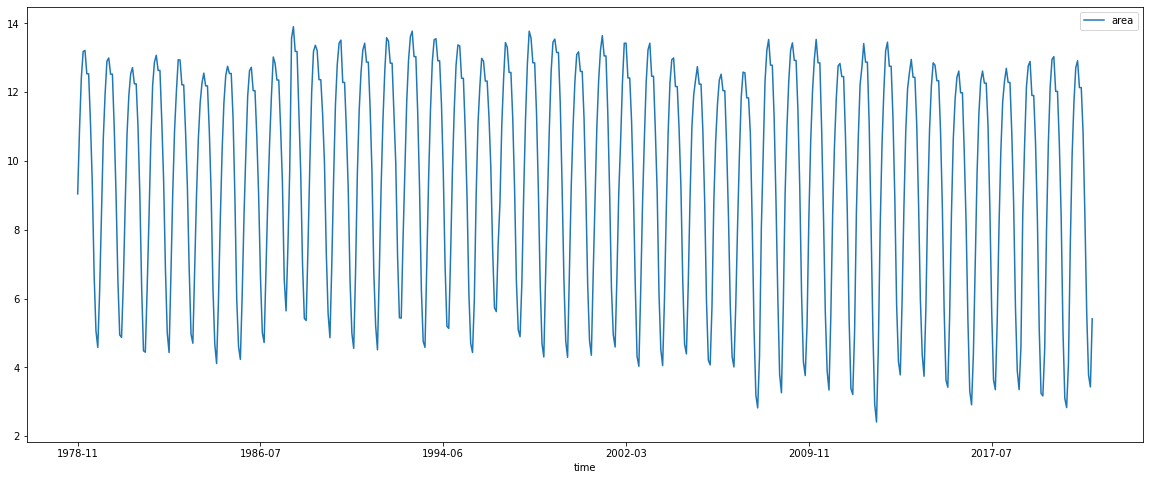

In [12]:
# Univariate Times Series data
df.plot(figsize=(20,8))
plt.show()

**The simple univariate time series plot above shows that ice thickness fluctuates over the year due to temperature changes by season. Based on this plot, we can observe the existence of some trends and seasonalities which helps us decide which forecasting model to use to fit the dataset. Although it may seem like the overall thickness has decreased over the years, we need more in-depth analysis to confidently state that that the ice thickness has decreased.**

### ACF & PACF

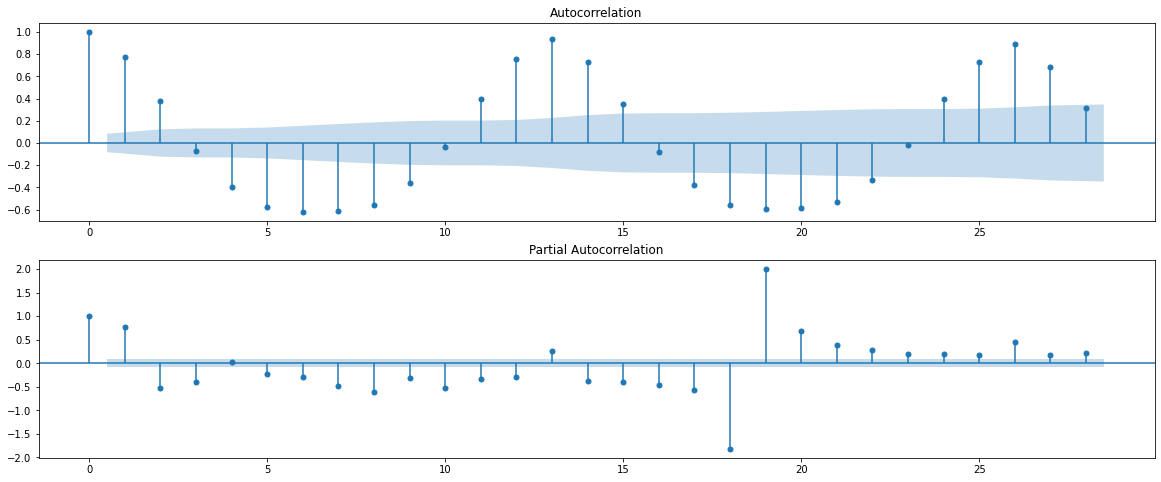

In [13]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['area'].diff().dropna(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['area'].diff().dropna(), ax=ax2)
plt.show()

### Decomposition of time series into trend, seasonal, and residual components

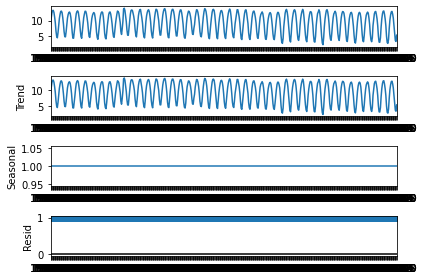

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative', freq=1)
result.plot()
plt.show()

In [17]:
df.shape

(556, 1)

**There is a total of 556 months of ice thickness records**

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 556 entries, 1978-11 to 2021-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   area    556 non-null    float64
dtypes: float64(1)
memory usage: 8.7+ KB


**We don't see any null values in the data set.**

**The average ice area is 9.52 with minimum and maximum being 2.41 and 13.9 respectively.**

In [27]:
print(df.head(1), df.tail(1))

         area
time         
1978-11  9.04          area
time         
2021-10  5.41


**The dataset contains measurements from November of 1978 to October of 2021.**

# Modeling

**In this part of the lab, we will exlore two time series methods, ARIMA and Holt Winters Exponential Smoothing, and compare their performance based on AIC.**

In [118]:
traindata, testdata = df.iloc[:402,0], df.iloc[402:,0]
print(traindata.tail())
testdata.head()

time
2009-08     4.16
2009-09     3.76
2009-10     5.24
2009-11     8.36
2009-12    10.59
Name: area, dtype: float64


time
2010-01    12.04
2010-02    12.96
2010-03    13.53
2010-04    12.85
2010-04    12.85
Name: area, dtype: float64

## ARIMA

**We will split the data into training and test dataset and predict ice areas starting from the year of 2010.**

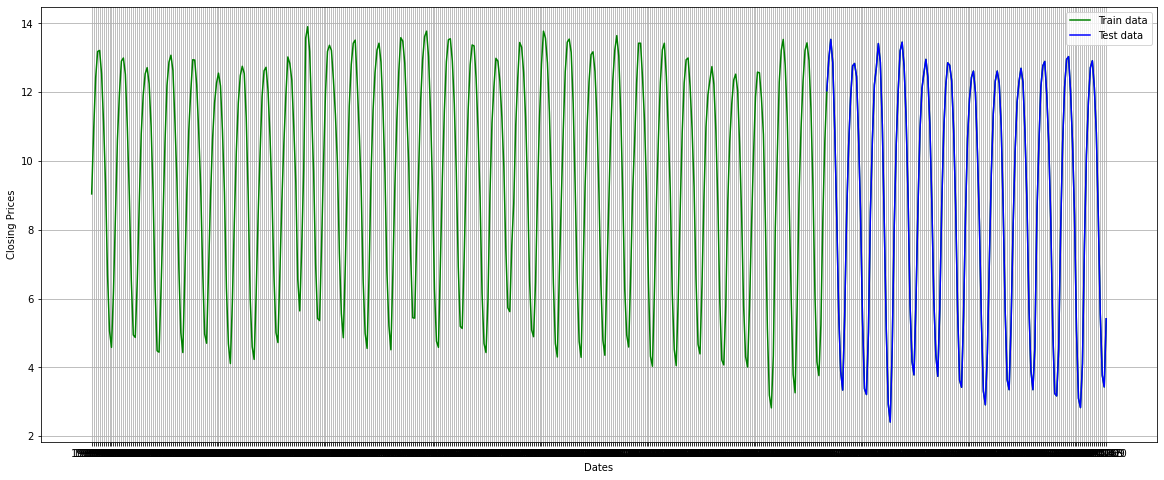

In [119]:
plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df, 'green', label='Train data')
plt.plot(testdata, 'blue', label='Test data')
plt.legend()
plt.show()

**We are going to build the ARIMA model on training data first**

In [127]:
# TRAINING
model = ARIMA(traindata, order=(1,1,1))
model_fit = model.fit(disp=0)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.area   No. Observations:                  401
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -558.820
Method:                       css-mle   S.D. of innovations              0.974
Date:                Fri, 12 Nov 2021   AIC                           1125.640
Time:                        18:43:28   BIC                           1141.616
Sample:                             1   HQIC                          1131.966
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0250      0.194      0.129      0.898      -0.356       0.406
ar.L1.D.area     0.6727      0.041     16.375      0.000       0.592       0.753
ma.L1.D.area     0.3161      0.040      7.982      0.000       0.239       0.394
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4865           +0.0000j            1.4865            0.0000
MA.1           -3.1633           +0.0000j            3.1633            0.5000
-----------------------------------------------------------------------------
"""

**ARIMA model predicts a given time series based on its own past values. It can be used for any nonseasonal series of numbers that exhibits patterns and is not a series of random events. The “AR” stands for autoregression, which refers to the model that shows a changing variable that regresses on its own prior or lagged values. In other words, it predicts future values based on past values. “I” stands for integrated, which means it observes the difference between static data values and previous values.“MA” represents the moving average, which is the dependency between an observed value and a residual error from a moving average model applied to previous observations.**

**In the ARIMA model (p,d,q), we use three parameters: AR (p=1), the number of lag observations or autoregressive terms in the model; I (d=1), the difference in the nonseasonal observations; and MA (q=1), the size of the moving average window.**

**The ARIMA model built from the training data results in a AIC value of 1125.640. AIC is an estimator of prediction error and measures the relative quality of statistical models for a given set of data. A normal AIC level is below 5.7%. We will use AIC as a measure to compare two models in later part of the lab.**

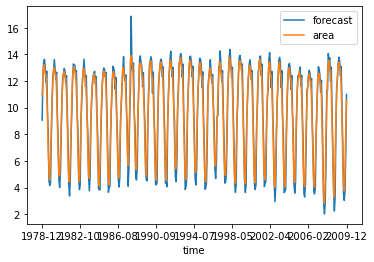

In [128]:
model_fit.plot_predict(dynamic=False)
plt.show()

<Figure size 720x432 with 0 Axes>

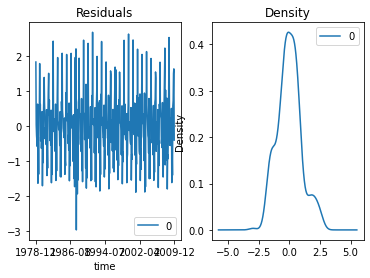

In [129]:
residuals = pd.DataFrame(model_fit.resid)

plt.figure(figsize=(10,6))
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

**Let's build a ARIMA model with the same order of parametrs for p,d,q and see how it performs on the test dataset."**

In [125]:
model3 = ARIMA(testdata, order=(1,1,1))
model_fit3 = model3.fit(disp=0)
model_fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.area   No. Observations:                  153
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -303.210
Method:                       css-mle   S.D. of innovations              1.742
Date:                Fri, 12 Nov 2021   AIC                            614.420
Time:                        18:42:48   BIC                            626.542
Sample:                             1   HQIC                           619.344
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0159      0.023     -0.697      0.486      -0.061       0.029
ar.L1.D.area     0.8781      0.041     21.310      0.000       0.797       0.959
ma.L1.D.area    -1.0000      0.016    -62.978      0.000      -1.031      -0.969
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1389           +0.0000j            1.1389            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

<Figure size 1440x576 with 0 Axes>

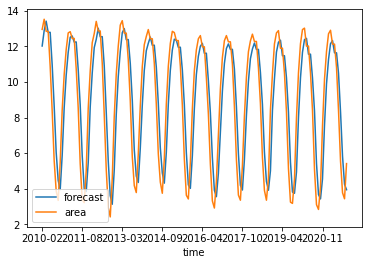

In [126]:
# Actual vs Fitted
plt.figure(figsize=(20,8))
model_fit3.plot_predict(dynamic=False)
plt.show()

<Figure size 720x432 with 0 Axes>

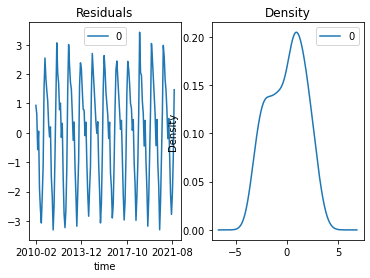

In [130]:
residuals3 = pd.DataFrame(model_fit3.resid)

plt.figure(figsize=(10,6))
fig, ax = plt.subplots(1,2)
residuals3.plot(title="Residuals", ax=ax[0])
residuals3.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

**We can observe that the AIC is lower for test data even if the order of parameters (p,d,q) were the same. Overall, our prediction does a fairly good job catching the general trend in the data. Although ARIMA is widely used for this kind of univate time series forecasting and can handle such a data with trends, we should be aware that ARIMA does not support time series with a seasonal component.**

## Holt Winters Exponetial Smoothing

In [163]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# fit model
model4 = ExponentialSmoothing(df, trend='mul', seasonal_periods=2, seasonal='add', damped=True)
model_fit4 = model4.fit()

In [164]:
model_fit4.summary()

Dep. Variable:,area,No. Observations:,556
Model:,ExponentialSmoothing,SSE,772.124
Optimized:,True,AIC,196.577
Trend:,Multiplicative,BIC,226.823
Seasonal:,Additive,AICC,196.907
Seasonal Periods:,2,Date:,"Fri, 12 Nov 2021"
Box-Cox:,False,Time:,20:57:33
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,1.0000000,beta,True


<Figure size 720x432 with 0 Axes>

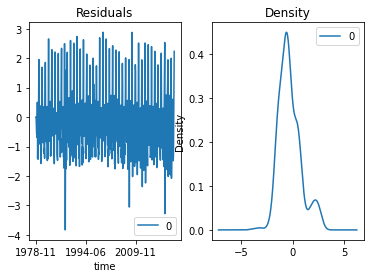

In [162]:
residuals4 = pd.DataFrame(model_fit4.resid)

plt.figure(figsize=(10,6))
fig, ax = plt.subplots(1,2)
residuals4.plot(title="Residuals", ax=ax[0])
residuals4.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

**Let's try different parameters this time.**

In [156]:
# fit model
model2 = ExponentialSmoothing(df, trend='mul', seasonal_periods=3, seasonal='mul', damped=True)
model_fit2 = model2.fit()

In [157]:
model_fit2.summary()

Dep. Variable:,area,No. Observations:,556
Model:,ExponentialSmoothing,SSE,674.783
Optimized:,True,AIC,123.655
Trend:,Multiplicative,BIC,158.221
Seasonal:,Multiplicative,AICC,124.058
Seasonal Periods:,3,Date:,"Fri, 12 Nov 2021"
Box-Cox:,False,Time:,20:56:28
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9999999,alpha,True
smoothing_trend,0.9999999,beta,True


<Figure size 720x432 with 0 Axes>

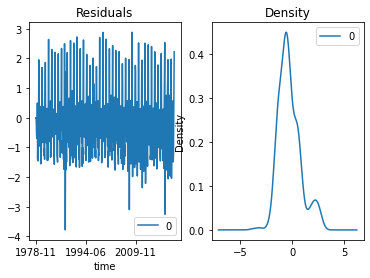

In [158]:
residuals2 = pd.DataFrame(model_fit2.resid)

plt.figure(figsize=(10,6))
fig, ax = plt.subplots(1,2)
residuals2.plot(title="Residuals", ax=ax[0])
residuals2.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

**Holt-Winters is one of the forecasting methods to model three aspects of the times series: average (level), trend over time, and seasonality (repeating pattern). It utilizes exponential smoothing, which allows more recent historical data to add more weights to forecasts than older data. Holt-Winters differ from simple exponential smoothing in that it allows forecasting of data with a trend and seasonality.**

**Some of the advantages of exponential smoothing in general is that it is not only very simple in concept and easy to understand, but its weighting process on recent historical data is very powerful in forecasting the future. In particular, as long as we find the right parameters, Holt-Winters can handle complicated seasonal patterns by finding the central value and adding in the effects of slope and seasonality.**

**However, the forecast may lag and fail to account for the dynamic changes in the real world scenario; therefore, it requires constant updating to respond to new information.**


**Compared to the ARIMA model, the Holt Winters Exponential Smoothing model has lower AIC due to its ability to handle seasonality on top of trend and level. Therefore, we can conclude that Holt Winters model performs better than ARIMA model for this specific dataset where both trend and seasonality exist.**

**Also, it is important to note that the difference in parameters play a huge role in decreasing the AIC for the Holt Winters model. Therefore, it's recommended to use hyper-parameter tuning to find the optimal parameters and build the best predictive model.**

## Conclusion

**In this lab, we performed time series forecasting on the sea-ice dataset and analyzed the ice thickness in Artic and Antarctic area on a monthly basis. The analysis included analyzing past trends as well as building times series models (ARIMA & Holt Winters Exponential Smoothing) to forecast future trends. We used AIC as a performance measure to compare ARIMA and Holt Winters model. While ARIMA can handle trends, it failed to capture seasonality in the dataset. On the other hand, Holt Winters Exponential Smoothing model's weighting process on recent historical data as well as its addition in the effects of slope and seasonality resulted in lower AIC and therefore a better model. Also, we observed that the parameters play a significant role in performance of the Holt Winters model. Therefore, in real practice, it is recommended to try hyperparameter tuning and diffrent forecasting algorithms to acheive the best predictive performance of the forecasting model.**